### практическая работа 3: создание набора данных из каталога изображений
Задание:

1. Создать собственный каталог изображений (не менее 4 категорий из не менее, чем 4 изображений)
   1.1 Сделать некоторые категории совпадающими с категориями CIFAR10 
2. Выполнить загрузку изображений в размеченный набор данных
3. Выполнить аугментацию набора данных с сохранением модифицированных изображений
4. Обучить или загрузить предобученную на CIFAR10 нейросеть
5. Выполнить распознавание некоторых загруженных и/или модифицированных изображений 

In [2]:
import os
from keras.utils import img_to_array, load_img
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import RandomFlip, RandomRotation,RandomZoom, RandomTranslation, Rescaling
from PIL import Image
from keras.models import Sequential
from keras.layers import Input, Rescaling, Conv2D, MaxPooling2D, Flatten, Dense
from PIL import Image
from tensorflow.keras.datasets import cifar10
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model


In [3]:
# Загружаем
path = "img"
targetNames = [] #массив для названий меток (каждого изображения!!!)
images = [] #массив данных изображений

contents = os.listdir(path) # получаем полностью всё содерэжимое каталога path и далее разбираем тольо подкаталоги как классы обхектов
for elem in contents:
    curDir = os.path.join( path, elem ) # для каждого объетка (файл или подкаталог) в каталоге path формируем полный путь 
    if os.path.isdir( curDir ): # если это каталог, то заходим в него и так же формируем список объктов
        print(f"{elem}")
        files = os.listdir( curDir )  # формируем список объектов в подкаталоге (могут быть и файлы, и каталоги)
        for fname in files:
            fpath = os.path.join( curDir, fname ) # так же формируем полный путь к объекту
            if os.path.isfile( fpath ): # на этот раз нас интересуют файлы. считаем, что там только картинки (лучше, конечно, фильтровать)
                # Фильтруем только изображения
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    try:
                        print(f"   {fname}")
                        targetNames.append(elem)  # добавляем название метки
                        img = load_img(fpath, target_size=(64, 64))  # загружаем изображение
                        images.append(img_to_array(img).astype(np.uint8))  # добавляем числовое представление
                    except (IOError, UnidentifiedImageError) as e:
                        print(f"Ошибка при загрузке изображения {fname}: {e}")
                        
images = np.array( images )
targetNames = np.array( targetNames )
len(images)

car
   car1.jpeg
   car3.jpeg
   car2.jpeg
dog
   dog1.jpeg
   dog3.jpeg
   dog2.jpeg
plane
   plane3.jpeg
   plane2.jpeg
   plane1.jpeg
frog
   frog2.jpeg
   frog3.jpeg
   frog1.jpeg
horse
   horse1.jpeg
   horse2.jpeg
   horse3.jpeg


15

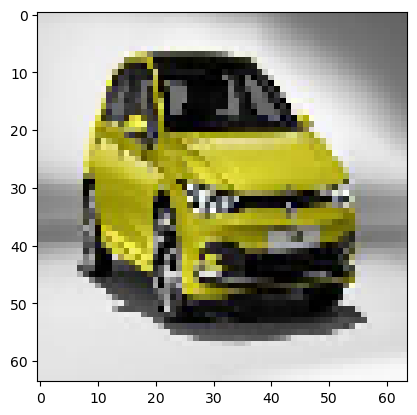

In [4]:
plt.imshow( images[1] )

In [5]:
targetNames

array(['car', 'car', 'car', 'dog', 'dog', 'dog', 'plane', 'plane',
       'plane', 'frog', 'frog', 'frog', 'horse', 'horse', 'horse'],
      dtype='<U5')

In [6]:
np.unique(targetNames)

array(['car', 'dog', 'frog', 'horse', 'plane'], dtype='<U5')

In [7]:
# у метода unique есть параметр return_inverse (по умолчанию выключен), который позволяет получить исходный массив в виде кодов уникальных значений 
np.unique(targetNames, return_inverse = True)

(array(['car', 'dog', 'frog', 'horse', 'plane'], dtype='<U5'),
 array([0, 0, 0, 1, 1, 1, 4, 4, 4, 2, 2, 2, 3, 3, 3]))

In [8]:
# только искомый массив нужно вытащить из tuple
targetLabels = np.unique(targetNames, return_inverse = True)[1]
targetLabels

array([0, 0, 0, 1, 1, 1, 4, 4, 4, 2, 2, 2, 3, 3, 3])

In [9]:
# Делим на трейн и тест и приводим все к одному размеру
(imgTrain, imgTest) = image_dataset_from_directory( path, 
                                     labels = "inferred", #Указывает, что метки (классы) будут автоматически извлечены из имен подкаталогов. Например, если у вас есть подкаталоги cats и dogs, то изображения в этих подкаталогах будут автоматически помечены как 0 для cats и 1 для dogs. 
                                     image_size = (224,224), 
                                     batch_size = 4,#Определяет количество изображений, которые будут загружаться в каждом батче.
                                    validation_split = 0.4, 
                                    seed = 42,
                                    subset =  "both"#Указывает, что вы хотите получить как обучающий, так и валидационный набор данных. 
                                     )

Found 15 files belonging to 5 classes.
Using 9 files for training.
Using 6 files for validation.


In [10]:
# Создаем сверточную модель для классификации изображений 

num_classes = len( imgTrain.class_names )  # количество классов

model = Sequential([
    Input( shape = (224,224, 3) ),       
    Rescaling( 1. / 255. ),               # нормализация возможна и непосредственно в виде служебног слоя ;)
    Conv2D( filters = 32 , kernel_size = (3,3), activation = 'relu' ),
    MaxPooling2D(),
    Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(units = 128, activation='relu'),
    Dense(units = num_classes, activation = 'softmax')  
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', 
    metrics=['sparse_categorical_accuracy']
)

# при обучении не нужно указывать раздельно входы и выходы. датасет Tensorflow уже включает входные данные и метки
history = model.fit( imgTrain, validation_data = imgTest, epochs = 10 ) # метод fit также может валидировать на тестовом наборе

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - loss: 13.4420 - sparse_categorical_accuracy: 0.2361 - val_loss: 9.8698 - val_sparse_categorical_accuracy: 0.1667
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 5.5022 - sparse_categorical_accuracy: 0.5347 - val_loss: 3.7557 - val_sparse_categorical_accuracy: 0.3333
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 4.4308 - sparse_categorical_accuracy: 0.2917 - val_loss: 2.9602 - val_sparse_categorical_accuracy: 0.3333
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 1.8594 - sparse_categorical_accuracy: 0.5278 - val_loss: 1.9957 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.3815 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.8124 - val_sparse_categorical_accuracy: 0.1667
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.0515 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.9340 - val_sparse_categorical_accuracy: 0.3333
Epoch 7/10


2025-05-29 20:00:06.204049: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


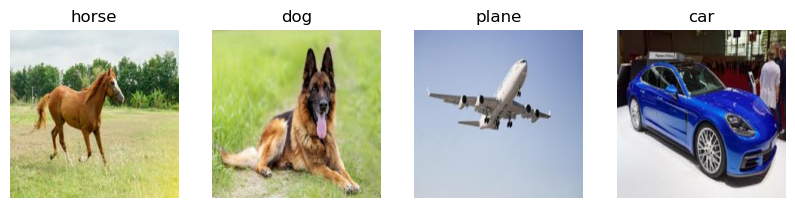

In [11]:
# Выводим первый батч

plt.figure( figsize = (10,10) )

for images, labels in imgTrain.take(1):    #take(1) берет 1 батч из набора
    for i in range( images.shape[0] ):  # images.shape[0] - первым параметром формы тензора указывается количество изображений в батче
        ax = plt.subplot(1, images.shape[0], i + 1 )
        plt.imshow( images[i].numpy().astype(np.uint8) )
        plt.title( imgTrain.class_names[ labels[i] ] )
        plt.axis("off")

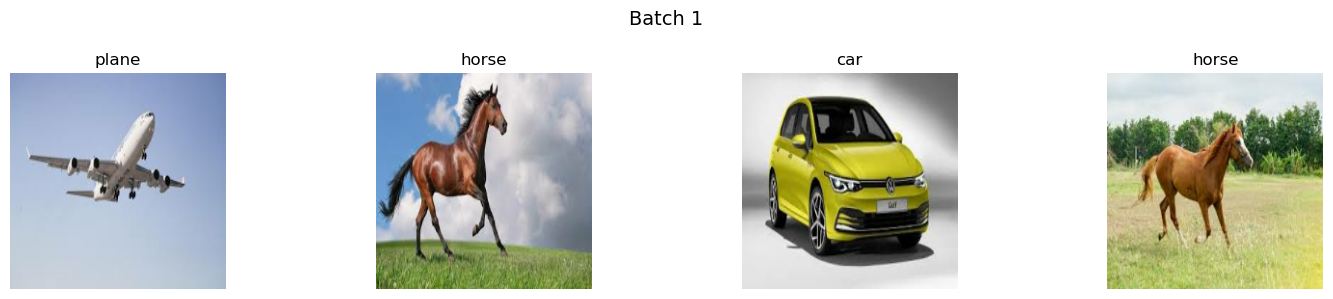

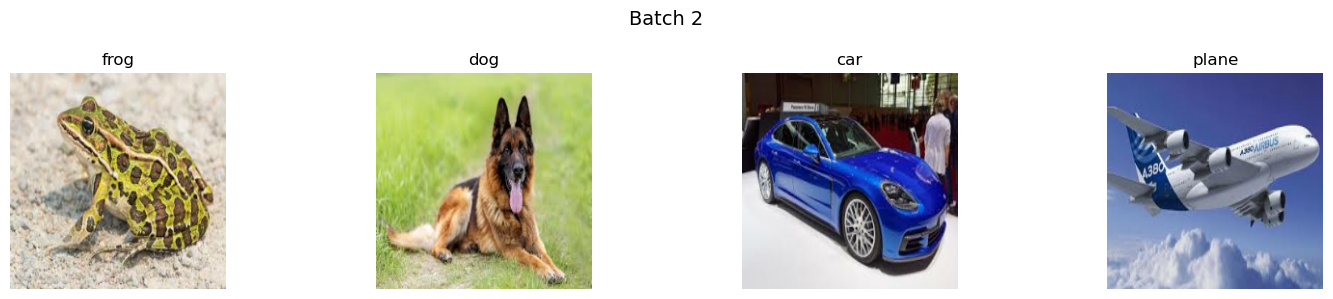

2025-05-29 20:00:06.660568: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
# выводим больше батчей

num_batches = 2

for batch_idx, (images, labels) in enumerate( imgTrain.take(num_batches) ):
    batch_size = images.shape[0]  # первым параметром формы тензора указывается количество изображений в батче
    plt.figure( figsize = (15, 3) )   # один батч в одну строку
    plt.suptitle( f"Batch {batch_idx + 1}", fontsize = 14 )

    # внутренний цикл — по изображениям в батче
    for i in range( batch_size ):  # если батч "вдруг случайно" оказался слишном большой, то лучше ограничить, например, десятком: min(batch_size, 10) 
        ax = plt.subplot(1, batch_size, i + 1 ) # в случае ограничения вместо batch_size, ставим максимальное, т.е., напрмер, 10
        plt.imshow( images[i].numpy().astype(np.uint8) )
        plt.title( imgTrain.class_names[labels[i]] )
        plt.axis( "off" )
    plt.tight_layout()
    plt.show()

In [13]:
# Аугментация и нормализация данных

dataAugmentation = Sequential([
    RandomFlip("horizontal"),            # случайное горизонтальное отражение (только в режиме training = True)
    RandomRotation(0.1),                 # случайный поворот в процентах (только в режиме training = True)
    RandomZoom(0.1),                     # зум в процентах (только в режиме training = True)
    RandomTranslation(0.1, 0.1)          # сдвиг по координатам в процентах (только в режиме training = True)
])

normalizationLayer = Rescaling(1./255)

# используем функцию map для изменения каждого элемента датасета с помощью лямбда-функции (применяется к каждой единице датасета - батчу)
# лямбда-функция отправляет каждый батч датасета на модель аугментации, состоящую из служебных слоев трансформации данных
# а также отдельные функции отправляют батчи на служебный слой масштабирования Rescaling
# важно также отметить, что аугментации подвергается только обучающий датасет!!! по причине того, что слои модели data_augmentation работают только в режиме обучения training = True

imgTrainAug = imgTrain.map( lambda x, y: (dataAugmentation(x, training = True), y) ) #включается флаг training, поскольку служебные слои работают только в режиме обучения 
imgTrainAugNorm = imgTrainAug.map(lambda x, y: (normalizationLayer(x), y))
imgTestNorm = imgTest.map(lambda x, y: (normalizationLayer(x), y))

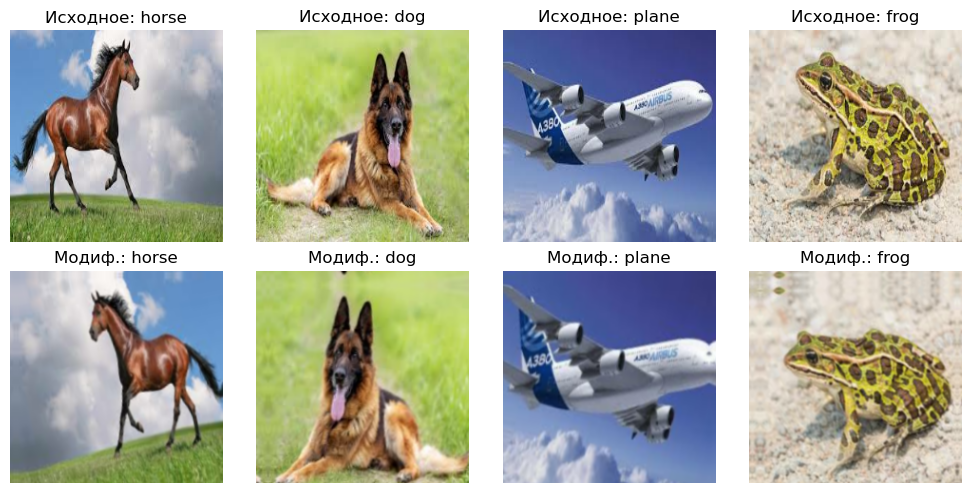

In [14]:
# верхний ряд - оригиналы нижний — аугментированные версии
# на примере одного батча

for images, labels in imgTrain.take(1):
    augBatch = dataAugmentation(images, training = True)  # training = True !!!

    plt.figure(figsize=(10, 5))
    for i in range( images.shape[0] ):
        # исходный оригинал
        ax = plt.subplot(2, images.shape[0], i + 1)
        plt.imshow( images[i].numpy().astype(np.uint8) )
        plt.title( "Исходное: " + imgTrain.class_names[labels[i]] )
        plt.axis( "off" )

        # рез-т аугментации
        ax = plt.subplot(2, images.shape[0], i + 1 + images.shape[0])
        plt.imshow(augBatch[i].numpy().astype(np.uint8))
        plt.title("Модиф.: " + imgTrain.class_names[labels[i]])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [15]:
# сохраняем 10 аугментирванных изображения 

saveAmount = 10

for images, labels in imgTrain.take(1):
    augmentedImgs = dataAugmentation(images, training = True)

    for i in range(min(len(images), saveAmount)):
        #label_index = labels[i].numpy()
        className = imgTrain.class_names[ labels[i] ]

        classDir = os.path.join(path, className)
        os.makedirs(classDir, exist_ok = True) # по идее, каталог должен сущестоввать. если все же его нет, то будет создан. если каталог есть, то в силу "exist_ok = True" не возникнет исключения

        # пусть имя файла: <класс>_aug_<номер>.png
        filename = f"{className}_aug_{i+1}.png"
        filepath = os.path.join(classDir, filename)

        # Сохраняем картинку
        img = augmentedImgs[i].numpy().astype(np.uint8)
        Image.fromarray(img).save(filepath)

        print(f"сохраняем {filepath}")

сохраняем img/plane/plane_aug_1.png
сохраняем img/plane/plane_aug_2.png
сохраняем img/car/car_aug_3.png
сохраняем img/horse/horse_aug_4.png


2025-05-29 20:00:07.193659: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [16]:
# создаем CNN для классификации изображений CIFAR-10

num_classes = 10  #CIFAR-10 имеет 10 классов

model = Sequential([
    Input(shape=(32, 32, 3)),  # Изменяем размер входа на 32x32 пикселя
    Rescaling(1. / 255.),  # Нормализация входных данных
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(units=128, activation='relu'),
    Dense(units=num_classes, activation='softmax')  # 10 классов для CIFAR-10
])

#Компилируем модель
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)


In [17]:
# Загружаем набор данных CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Нормализация данных
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Обучение модели
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 2.1641 - sparse_categorical_accuracy: 0.1927 - val_loss: 1.9627 - val_sparse_categorical_accuracy: 0.3036
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 1.8901 - sparse_categorical_accuracy: 0.3230 - val_loss: 1.8129 - val_sparse_categorical_accuracy: 0.3561
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 1.7786 - sparse_categorical_accuracy: 0.3637 - val_loss: 1.7603 - val_sparse_categorical_accuracy: 0.3696
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 1.7265 - sparse_categorical_accuracy: 0.3830 - val_loss: 1.7213 - val_sparse_categorical_accuracy: 0.3835
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 1.6783 - sparse_categorical_accuracy: 0.3973 - val_loss: 1.6354 - val_sparse_categorical_accuracy: 0.4168
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 1.6311 - sparse_categorical_accuracy: 0.4173 - val_loss: 1.6067 - val_sparse_categorical_ac

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


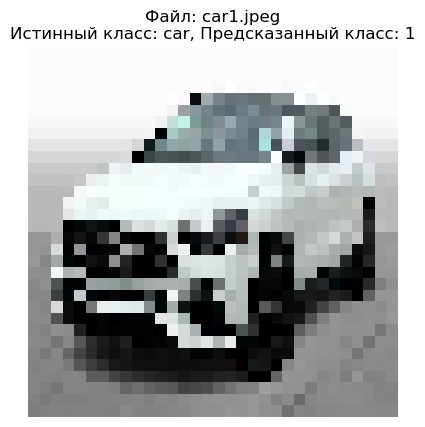

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


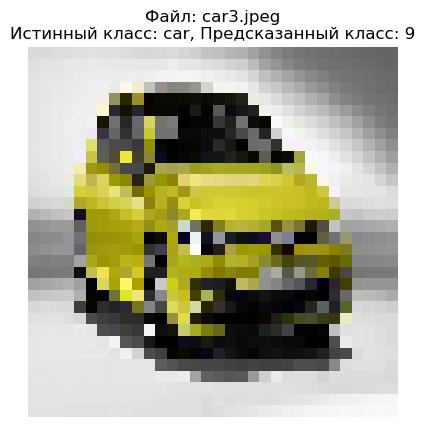

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


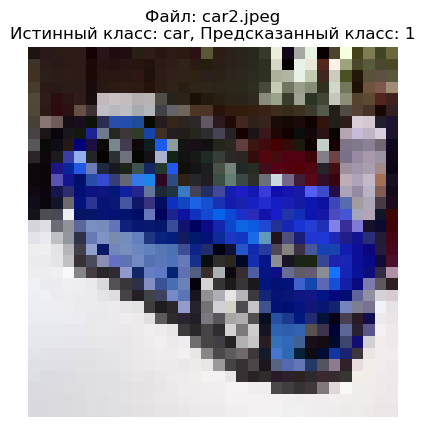

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


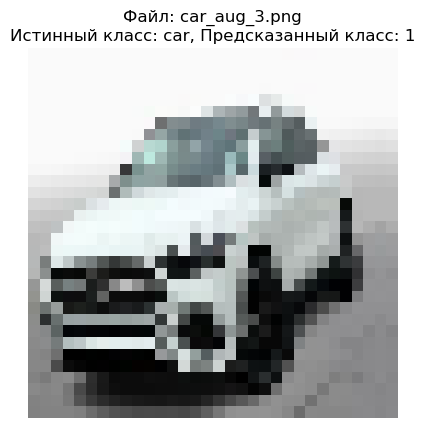

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


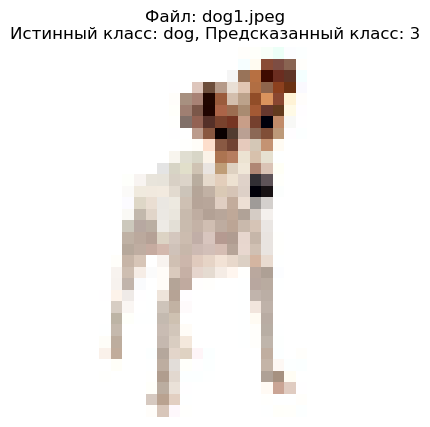

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


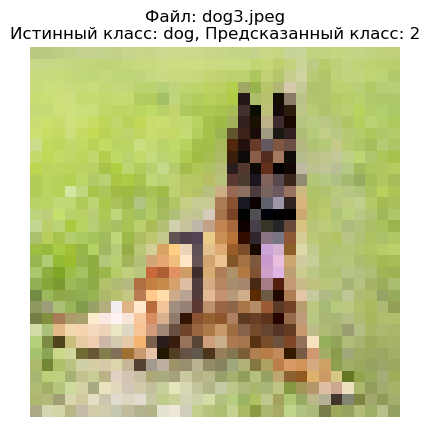

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


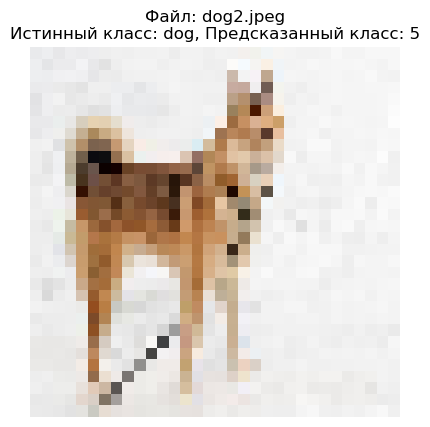

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


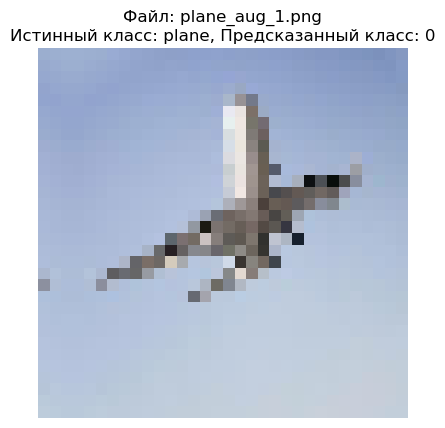

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


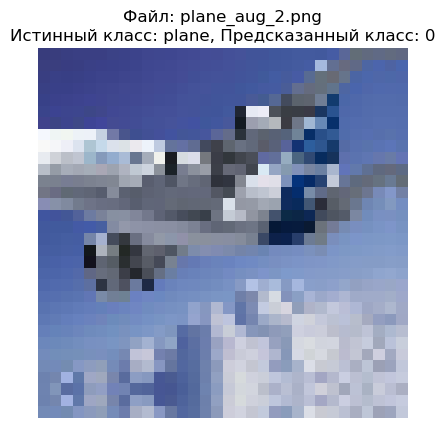

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


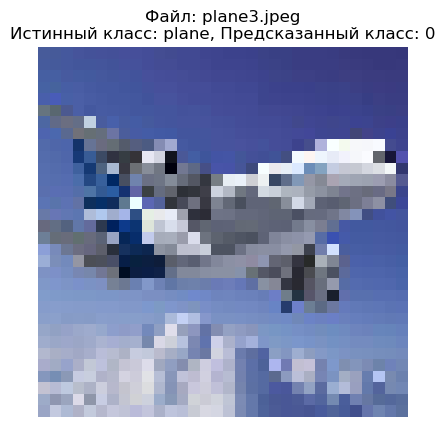

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


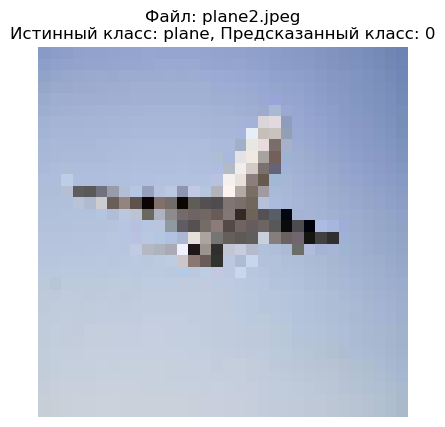

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


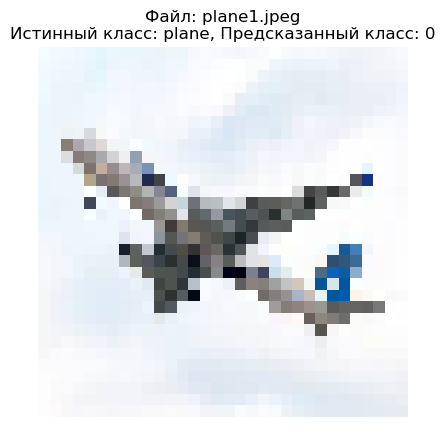

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


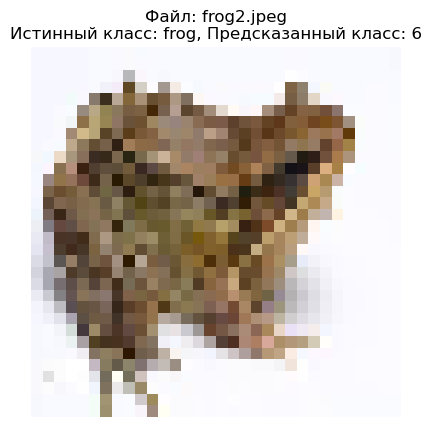

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


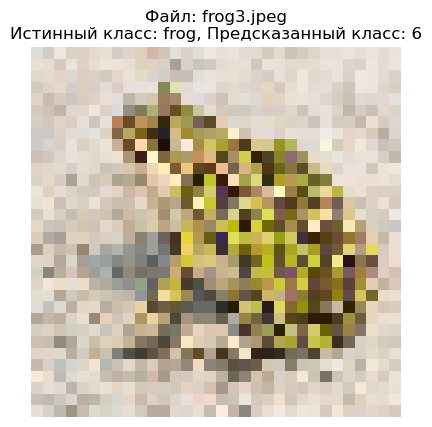

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


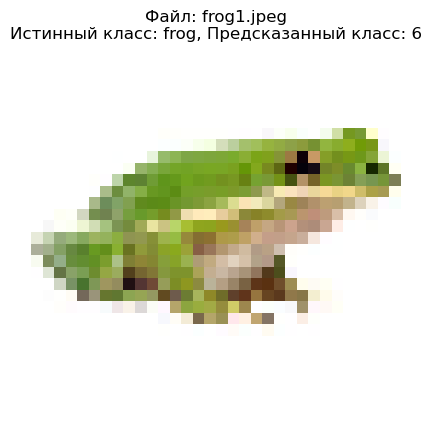

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


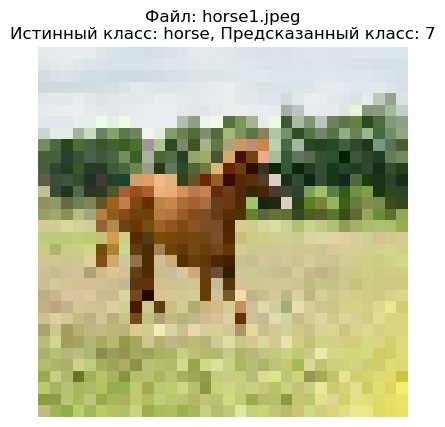

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


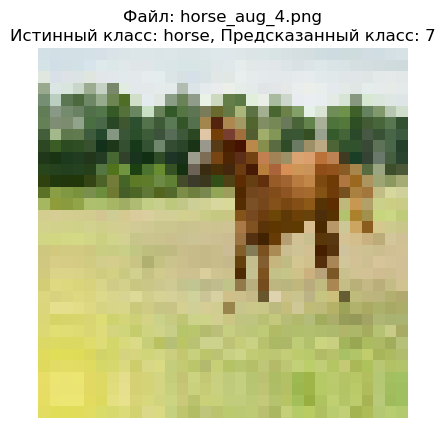

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


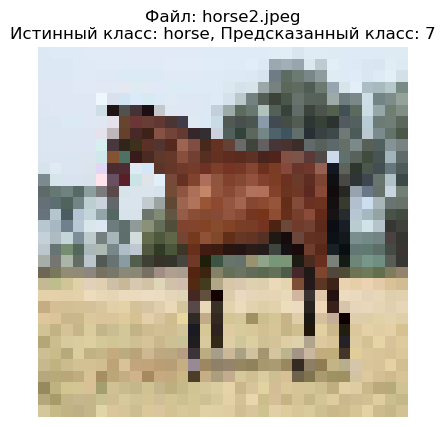

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


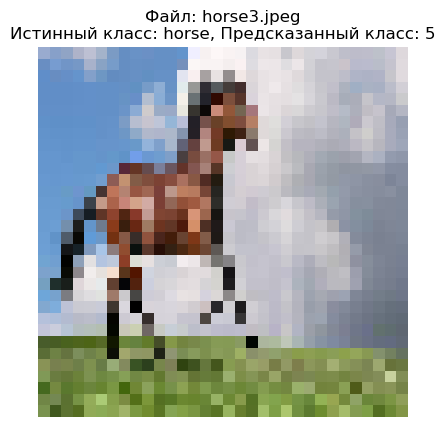


Итоговые предсказания:
Файл: car1.jpeg, Истинный класс: car, Предсказанный класс: 1
Файл: car3.jpeg, Истинный класс: car, Предсказанный класс: 9
Файл: car2.jpeg, Истинный класс: car, Предсказанный класс: 1
Файл: car_aug_3.png, Истинный класс: car, Предсказанный класс: 1
Файл: dog1.jpeg, Истинный класс: dog, Предсказанный класс: 3
Файл: dog3.jpeg, Истинный класс: dog, Предсказанный класс: 2
Файл: dog2.jpeg, Истинный класс: dog, Предсказанный класс: 5
Файл: plane_aug_1.png, Истинный класс: plane, Предсказанный класс: 0
Файл: plane_aug_2.png, Истинный класс: plane, Предсказанный класс: 0
Файл: plane3.jpeg, Истинный класс: plane, Предсказанный класс: 0
Файл: plane2.jpeg, Истинный класс: plane, Предсказанный класс: 0
Файл: plane1.jpeg, Истинный класс: plane, Предсказанный класс: 0
Файл: frog2.jpeg, Истинный класс: frog, Предсказанный класс: 6
Файл: frog3.jpeg, Истинный класс: frog, Предсказанный класс: 6
Файл: frog1.jpeg, Истинный класс: frog, Предсказанный класс: 6
Файл: horse1.jpeg, Исти

In [18]:
# каждое изображение делаем предсказание и записываем в predictions

# Функция для загрузки и предобработки изображений
def load_and_preprocess_image(filepath):
    img = load_img(filepath, target_size=(32, 32))  # Изменяем размер на 32x32 для CIFAR-10
    img_array = img_to_array(img)  # Преобразуем в массив
    img_array = img_array / 255.0  # Нормализация
    return img_array, img  # Возвращаем и массив, и объект изображения для отображения



# Список для хранения предсказаний
predictions = []

# Проходим по всем классам и их изображениям
for class_name in os.listdir(path):
    class_dir = os.path.join(path, class_name)
    if os.path.isdir(class_dir):
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.png', '.jpeg', '.jpg')):  # Проверяем, что это изображение
                filepath = os.path.join(class_dir, filename)
                img_array, img = load_and_preprocess_image(filepath)
                img_array = np.expand_dims(img_array, axis=0)  # Добавляем размерность для батча
                
                # Предсказание класса
                prediction = model.predict(img_array)
                predicted_class = np.argmax(prediction, axis=1)[0]  # Получаем индекс класса с максимальной вероятностью
                predictions.append((filename, class_name, predicted_class))
                
                # Отображение картинки
                plt.imshow(img)
                plt.title(f"Файл: {filename}\nИстинный класс: {class_name}, Предсказанный класс: {predicted_class}")
                plt.axis('off')
                plt.show()

In [38]:
print("\nИтоговые предсказания:")
for filename, true_class, predicted_class in predictions:
    print(f"Файл: {filename}, Истинный класс: {true_class}, Предсказанный класс: {predicted_class}")


Итоговые предсказания:
Файл: car1.jpeg, Истинный класс: car, Предсказанный класс: 1
Файл: car3.jpeg, Истинный класс: car, Предсказанный класс: 9
Файл: car2.jpeg, Истинный класс: car, Предсказанный класс: 1
Файл: car_aug_3.png, Истинный класс: car, Предсказанный класс: 1
Файл: dog1.jpeg, Истинный класс: dog, Предсказанный класс: 3
Файл: dog3.jpeg, Истинный класс: dog, Предсказанный класс: 2
Файл: dog2.jpeg, Истинный класс: dog, Предсказанный класс: 5
Файл: plane_aug_1.png, Истинный класс: plane, Предсказанный класс: 0
Файл: plane_aug_2.png, Истинный класс: plane, Предсказанный класс: 0
Файл: plane3.jpeg, Истинный класс: plane, Предсказанный класс: 0
Файл: plane2.jpeg, Истинный класс: plane, Предсказанный класс: 0
Файл: plane1.jpeg, Истинный класс: plane, Предсказанный класс: 0
Файл: frog2.jpeg, Истинный класс: frog, Предсказанный класс: 6
Файл: frog3.jpeg, Истинный класс: frog, Предсказанный класс: 6
Файл: frog1.jpeg, Истинный класс: frog, Предсказанный класс: 6
Файл: horse1.jpeg, Исти

- airplane (самолет) - метка 0
- automobile (автомобиль) - метка 1
- bird (птица) - метка 2
- cat (кот) - метка 3
- deer (олень) - метка 4
- dog (собака) - метка 5
- frog (лягушка) - метка 6
- horse (лошадь) - метка 7
- ship (корабль) - метка 8
- truck (грузовик) - метка 9